# IBB Intermediate Checkpoint

#### Requirements

```
pip install matplotlib --user
pip install opencv-python --user
pip install numpy --user
pip install scikit-learn --user
pip install pandas --user
pip install scikit-image --user
```

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math
import os
import pandas as pd
from skimage.feature import local_binary_pattern
from sklearn.metrics.pairwise import cosine_similarity

# Reading all images and saving them
image_list = []
dim = (128,128)

for folder_number in range(1,101):
    folder_name = f'{folder_number:03d}'
    
    for image_number in range(1,11):
        image_name = f'{image_number:02d}'
        # image = cv2.imread("../awe/"+folder_name+"/"+image_name+".png")

        # If in Faculty computers 
        path = os.path.join(os.getcwd(), "awe", folder_name, image_name)
        image = cv2.imread(path+".png")
        # print(image, folder_name, image_name, path+".png", os.getcwd())

        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
        image_list.append(np.array(image))
  
# Now, the variable 'image_list[x]' stores the pixel values of image

In [2]:
image_list_by_class = [image_list[i:i+10] for i in range(0, len(image_list), 10)]

In [3]:
# Converting 2D image into a 1D vector for baseline
image_vector_list = []

for image in image_list:
    image_vector_list.append(np.ravel(image))


#### Utility functions

In [4]:
def build_matrix_from_list(list):
    dim = int(math.sqrt(len(list)))
    list = np.array(list)
    matrix = []

    while list.size != 0:
        matrix.append(list[:dim])
        list = list[dim:]
    
    return matrix

In [5]:
def show_feature_vector(feature_vector):
    # x = np.array(feature_vector)
    # dim = int(math.sqrt(len(feature_vector)))
    matrix = build_matrix_from_list(feature_vector)

    image = np.array(matrix, copy=False) / 255.0
    plt.imshow(image) 
    plt.axis('off')
    plt.show()

### LBP feature extractors

In [6]:
# Baseline LBP 

# Receives an image vector and the dimension of the LBP local window 
# Returns the image feature vector
def baselineLBP(image, dimLBP):
    radius = int((dimLBP - 1)/2)
    matrix_divided = []
    matrixLBP = []
    feature_vector = []
    
    # Add padding to a picture that is not divisible by the dimension of the LBP feature extraction matrix
    numberOfPadding = dimLBP - (image.shape[0] % dimLBP)
    image = cv2.copyMakeBorder(image, 0, numberOfPadding, 0, numberOfPadding, cv2.BORDER_CONSTANT, 0) 
    
    for width in range(radius, image.shape[0], dimLBP):
        for height in range(radius, image.shape[1], dimLBP):

            # Builds LBP feature extraction matrix
            m = [[image[width-radius][height-radius], image[width][height-radius], image[width+radius][height-radius]],
                        [image[width-radius][height], image[width][height], image[width+radius][height]],
                        [image[width-radius][height+radius], image[width][height+radius], image[width+radius][height+radius]]]
            matrix_divided.append(m)
            
            # Converts values in the extraction matrix to binary (if element < central element then 0 else 1)
            m2 = [[0 if m[row][element] < m[1][1] else 1 for element in range(0, 3)] for row in range(0, 3)] 
            matrixLBP.append(m2)
            
            # Building the LBP values (clockwise) and add them to the feature vector
            value = 1*m2[0][0] + 2*m2[0][1] + 4*m2[0][2] + 8*m2[1][2] + 16*m2[2][2] + 32*m2[2][1] + 64*m2[2][0] + 128*m2[1][0]
            feature_vector.append(value)
    
    return feature_vector

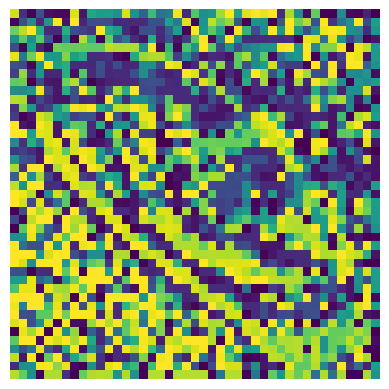

In [7]:
result = baselineLBP(image_list[0], 3)
show_feature_vector(result)

# cosine_similarity(image_list[0].ravel(), result)

In [8]:
# Overlapping LBP 

# Receives an image vector and the dimension of the LBP local window 
# Returns the [image feature vector, binary
def overlappingLBP(image, dimLBP, step):
    radius = int((dimLBP - 1)/2)
    matrix_divided = []
    matrixLBP = []
    feature_vector = []
    
    # Add padding to a picture that is not divisible by the dimension of the LBP feature extraction matrix
    numberOfPadding = dimLBP - (image.shape[0] % dimLBP)
    image = cv2.copyMakeBorder(image, 0, numberOfPadding, 0, numberOfPadding, cv2.BORDER_CONSTANT, 0) 
    
    # Changing the step of the for loops from the dimention of the LBP window to 1 makes the LBP window overlap
    for width in range(radius, image.shape[0]-(radius+step), step):
        for height in range(radius, image.shape[1]-(radius+step), step):
            
            # Builds LBP feature extraction matrix
            m = [[image[width-radius][height-radius], image[width][height-radius], image[width+radius][height-radius]],
                        [image[width-radius][height], image[width][height], image[width+radius][height]],
                        [image[width-radius][height+radius], image[width][height+radius], image[width+radius][height+radius]]]
            matrix_divided.append(m)
            
            # Converts values in the extraction matrix to binary (if element < central element then 0 else 1)
            m2 = [[0 if m[row][element] < m[1][1] else 1 for element in range(0, 3)] for row in range(0, 3)] 
            matrixLBP.append(m2)
            
            # Building the LBP values (clockwise) and add them to the feature vector
            value = 1*m2[0][0] + 2*m2[0][1] + 4*m2[0][2] + 8*m2[1][2] + 16*m2[2][2] + 32*m2[2][1] + 64*m2[2][0] + 128*m2[1][0]
            feature_vector.append(value)
    
    return feature_vector

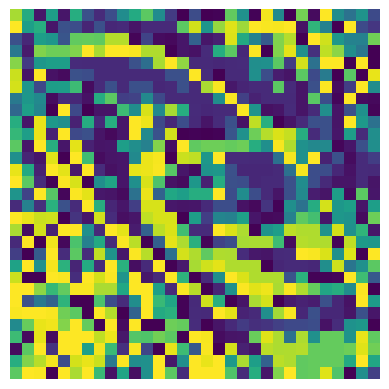

In [9]:
result = overlappingLBP(image_list[0], 7, 4)
show_feature_vector(result)

In [10]:
# Uniform LBP 

# Receives an image vector and the dimension of the LBP local window 
# Returns the uniform image feature vector
def uniformLBP(image, dimLBP):
    radius = int((dimLBP - 1)/2)
    matrix_divided = []
    matrixLBP = []
    feature_vector = []
    
    # Add padding to a picture that is not divisible by the dimension of the LBP feature extraction matrix
    numberOfPadding = dimLBP - (image.shape[0] % dimLBP)
    image = cv2.copyMakeBorder(image, 0, numberOfPadding, 0, numberOfPadding, cv2.BORDER_CONSTANT, 0) 
    
    for width in range(radius, image.shape[0], dimLBP):
        for height in range(radius, image.shape[1], dimLBP):
            
            # Builds LBP feature extraction matrix
            m = [[image[width-radius][height-radius], image[width][height-radius], image[width+radius][height-radius]],
                        [image[width-radius][height], image[width][height], image[width+radius][height]],
                        [image[width-radius][height+radius], image[width][height+radius], image[width+radius][height+radius]]]
            matrix_divided.append(m)
            
            # Converts values in the extraction matrix to binary (if element < central element then 0 else 1)
            m2 = [[0 if m[row][element] < m[1][1] else 1 for element in range(0, 3)] for row in range(0, 3)] 
            matrixLBP.append(m2)
            
            # Build uniform binary list (clockwise)
            uniform_binary_list = [m2[0][0], m2[0][1], m2[0][2], m2[1][2], m2[2][2], m2[2][1], m2[2][0], m2[1][0]]
            
            # uniform_binary_list = 
            uniform_binary_list.sort(reverse=False) 
            
            # Building the LBP values (clockwise) and add them to the feature vector            
            value = 1*uniform_binary_list[0] + 2*uniform_binary_list[1] + 4*uniform_binary_list[2] + 8*uniform_binary_list[3] + 16*uniform_binary_list[4] + 32*uniform_binary_list[5] + 64*uniform_binary_list[6] + 128*uniform_binary_list[7]
            feature_vector.append(value)
    
    return feature_vector

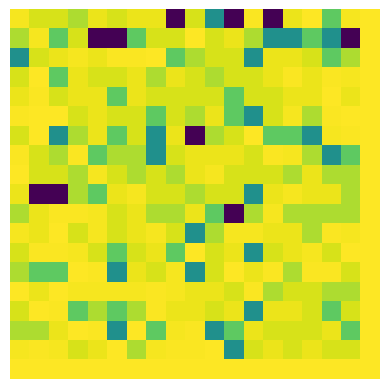

In [11]:
result = uniformLBP(image_list[0], 7)
show_feature_vector(result)

### Rank-1

In [24]:
# All LBPs
all_baseline_LBPs = [baselineLBP(image_list[i], 3) for i in range(len(image_list))]
all_baseline_LBPs_by_class = [all_baseline_LBPs[i:i+10] for i in range(0, len(all_baseline_LBPs), 10)]

all_5x5_LBPs = [baselineLBP(image_list[i], 5) for i in range(len(image_list))]
all_5x5_LBPs_by_class = [all_5x5_LBPs[i:i+10] for i in range(0, len(all_5x5_LBPs), 10)]

all_7x7_LBPs = [baselineLBP(image_list[i], 7) for i in range(len(image_list))]
all_7x7_LBPs_by_class = [all_7x7_LBPs[i:i+10] for i in range(0, len(all_7x7_LBPs), 10)]

all_9x9_LBPs = [baselineLBP(image_list[i], 9) for i in range(len(image_list))]
all_9x9_LBPs_by_class = [all_9x9_LBPs[i:i+10] for i in range(0, len(all_9x9_LBPs), 10)]

all_11x11_LBPs = [baselineLBP(image_list[i], 11) for i in range(len(image_list))]
all_11x11_LBPs_by_class = [all_11x11_LBPs[i:i+10] for i in range(0, len(all_11x11_LBPs), 10)]

In [84]:
# All Overlapping LBPs, overlap = radius
all_overlapping_3x3_LBPs = [overlappingLBP(image_list[i], 3, 2) for i in range(len(image_list))]
all_overlapping_3x3_LBPs_by_class = [all_overlapping_3x3_LBPs[i:i+10] for i in range(0, len(all_overlapping_3x3_LBPs), 10)]

all_overlapping_5x5_LBPs = [overlappingLBP(image_list[i], 5, 3) for i in range(len(image_list))]
all_overlapping_5x5_LBPs_by_class = [all_overlapping_5x5_LBPs[i:i+10] for i in range(0, len(all_overlapping_5x5_LBPs), 10)]

all_overlapping_7x7_LBPs = [overlappingLBP(image_list[i], 7, 4) for i in range(len(image_list))]
all_overlapping_7x7_LBPs_by_class = [all_overlapping_7x7_LBPs[i:i+10] for i in range(0, len(all_overlapping_7x7_LBPs), 10)]

all_overlapping_9x9_LBPs = [overlappingLBP(image_list[i], 9, 5) for i in range(len(image_list))]
all_overlapping_9x9_LBPs_by_class = [all_overlapping_9x9_LBPs[i:i+10] for i in range(0, len(all_overlapping_9x9_LBPs), 10)]

all_overlapping_11x11_LBPs = [overlappingLBP(image_list[i], 11, 6) for i in range(len(image_list))]
all_overlapping_11x11_LBPs_by_class = [all_overlapping_11x11_LBPs[i:i+10] for i in range(0, len(all_overlapping_11x11_LBPs), 10)]

In [12]:
# All Uniform LBPs
all_uniform_3x3_LBPs = [uniformLBP(image_list[i], 3) for i in range(len(image_list))]
all_uniform_3x3_LBPs_by_class = [all_uniform_3x3_LBPs[i:i+10] for i in range(0, len(all_uniform_3x3_LBPs), 10)]

all_uniform_5x5_LBPs = [uniformLBP(image_list[i], 5) for i in range(len(image_list))]
all_uniform_5x5_LBPs_by_class = [all_uniform_5x5_LBPs[i:i+10] for i in range(0, len(all_uniform_5x5_LBPs), 10)]

all_uniform_7x7_LBPs = [uniformLBP(image_list[i], 7) for i in range(len(image_list))]
all_uniform_7x7_LBPs_by_class = [all_uniform_7x7_LBPs[i:i+10] for i in range(0, len(all_uniform_7x7_LBPs), 10)]

all_uniform_9x9_LBPs = [uniformLBP(image_list[i], 9) for i in range(len(image_list))]
all_uniform_9x9_LBPs_by_class = [all_uniform_9x9_LBPs[i:i+10] for i in range(0, len(all_uniform_9x9_LBPs), 10)]

all_uniform_11x11_LBPs = [uniformLBP(image_list[i], 11) for i in range(len(image_list))]
all_uniform_11x11_LBPs_by_class = [all_uniform_11x11_LBPs[i:i+10] for i in range(0, len(all_uniform_11x11_LBPs), 10)]

In [35]:
all_scikit_LBPs = [np.ravel(local_binary_pattern(image_list[i],8,4,method='default')) for i in range(len(image_list))]
all_scikit_LBPs_by_class = [all_scikit_LBPs[i:i+10] for i in range(0, len(all_scikit_LBPs), 10)]

In [57]:
# Returns a list of size 100 with the flattened images
def precompute_all_averages_pixel_by_pixel():
    all_averages_pre_computed = [np.ravel(np.mean(image_list_by_class[i], axis=0)) for i in range(len(image_list_by_class))]
    return np.array(all_averages_pre_computed)

# Returns a flattened 128x128 matrix
def compute_average_of_class_pixel_by_pixel(class_number, image_index_to_remove):
    image_list_processed = np.delete(image_list_by_class[class_number], image_index_to_remove, axis=0)
    updated_average = np.mean(image_list_processed, axis=0)
    return np.ravel(updated_average)

In [58]:
# Baseline LBP -> window dimension 3x3 -> radius = 1
# Returns a list of size 100 with the a feature vector for each class
def precompute_all_averages_baseline_LBP():
    all_averages_pre_computed = [np.ravel(np.mean(all_baseline_LBPs_by_class[i], axis=0)) for i in range(len(all_baseline_LBPs_by_class))]
    return np.array(all_averages_pre_computed)

# Returns a flattened 128x128 matrix
def compute_average_of_class_baseline_LBP(class_number, image_index_to_remove):
    image_list_processed = np.delete(all_baseline_LBPs_by_class[class_number], image_index_to_remove, axis=0)
    updated_average = np.mean(image_list_processed, axis=0)
    return np.ravel(updated_average)

In [59]:
# Baseline LBP -> window dimension 5x5 -> radius = 2
# Returns a list of size 100 with the a feature vector for each class
def precompute_all_averages_5x5_LBP():
    all_averages_pre_computed = [np.ravel(np.mean(all_5x5_LBPs_by_class[i], axis=0)) for i in range(len(all_5x5_LBPs_by_class))]
    return np.array(all_averages_pre_computed)

# Returns a flattened 128x128 matrix
def compute_average_of_class_5x5_LBP(class_number, image_index_to_remove):
    image_list_processed = np.delete(all_5x5_LBPs_by_class[class_number], image_index_to_remove, axis=0)
    updated_average = np.mean(image_list_processed, axis=0)
    return np.ravel(updated_average)

In [60]:
# Baseline LBP -> window dimension 7x7 -> radius = 3
# Returns a list of size 100 with the a feature vector for each class
def precompute_all_averages_7x7_LBP():
    all_averages_pre_computed = [np.ravel(np.mean(all_7x7_LBPs_by_class[i], axis=0)) for i in range(len(all_7x7_LBPs_by_class))]
    return np.array(all_averages_pre_computed)

# Returns a flattened 128x128 matrix
def compute_average_of_class_7x7_LBP(class_number, image_index_to_remove):
    image_list_processed = np.delete(all_7x7_LBPs_by_class[class_number], image_index_to_remove, axis=0)
    updated_average = np.mean(image_list_processed, axis=0)
    return np.ravel(updated_average)

In [61]:
# Baseline LBP -> window dimension 9x9 -> radius = 4
# Returns a list of size 100 with the a feature vector for each class
def precompute_all_averages_9x9_LBP():
    all_averages_pre_computed = [np.ravel(np.mean(all_9x9_LBPs_by_class[i], axis=0)) for i in range(len(all_9x9_LBPs_by_class))]
    return np.array(all_averages_pre_computed)

# Returns a flattened 128x128 matrix
def compute_average_of_class_9x9_LBP(class_number, image_index_to_remove):
    image_list_processed = np.delete(all_9x9_LBPs_by_class[class_number], image_index_to_remove, axis=0)
    updated_average = np.mean(image_list_processed, axis=0)
    return np.ravel(updated_average)

In [62]:
# Baseline LBP -> window dimension 11x11 -> radius = 5
# Returns a list of size 100 with the a feature vector for each class
def precompute_all_averages_11x11_LBP():
    all_averages_pre_computed = [np.ravel(np.mean(all_11x11_LBPs_by_class[i], axis=0)) for i in range(len(all_11x11_LBPs_by_class))]
    return np.array(all_averages_pre_computed)

# Returns a flattened 128x128 matrix
def compute_average_of_class_11x11_LBP(class_number, image_index_to_remove):
    image_list_processed = np.delete(all_11x11_LBPs_by_class[class_number], image_index_to_remove, axis=0)
    updated_average = np.mean(image_list_processed, axis=0)
    return np.ravel(updated_average)

In [98]:
# Overlapping LBP -> window dimension 3x3 -> radius = 1, overlapping by x=radius
# Returns a list of size 100 with the a feature vector for each class
def precompute_all_averages_overlapping_3x3_LBP():
    all_averages_pre_computed = [np.ravel(np.mean(all_overlapping_3x3_LBPs_by_class[i], axis=0)) for i in range(len(all_overlapping_3x3_LBPs_by_class))]
    return np.array(all_averages_pre_computed)

# Returns a flattened 128x128 matrix
def compute_average_of_class_overlapping_3x3_LBP(class_number, image_index_to_remove):
    image_list_processed = np.delete(all_overlapping_3x3_LBPs_by_class[class_number], image_index_to_remove, axis=0)
    updated_average = np.mean(image_list_processed, axis=0)
    return np.ravel(updated_average)

In [100]:
# Overlapping LBP -> window dimension 5x5 -> radius = 2, overlapping by x=radius
# Returns a list of size 100 with the a feature vector for each class
def precompute_all_averages_overlapping_5x5_LBP():
    all_averages_pre_computed = [np.ravel(np.mean(all_overlapping_5x5_LBPs_by_class[i], axis=0)) for i in range(len(all_overlapping_5x5_LBPs_by_class))]
    return np.array(all_averages_pre_computed)

# Returns a flattened 128x128 matrix
def compute_average_of_class_overlapping_5x5_LBP(class_number, image_index_to_remove):
    image_list_processed = np.delete(all_overlapping_5x5_LBPs_by_class[class_number], image_index_to_remove, axis=0)
    updated_average = np.mean(image_list_processed, axis=0)
    return np.ravel(updated_average)

In [101]:
# Overlapping LBP -> window dimension 7x7 -> radius = 3, overlapping by x=radius
# Returns a list of size 100 with the a feature vector for each class
def precompute_all_averages_overlapping_7x7_LBP():
    all_averages_pre_computed = [np.ravel(np.mean(all_overlapping_7x7_LBPs_by_class[i], axis=0)) for i in range(len(all_overlapping_7x7_LBPs_by_class))]
    return np.array(all_averages_pre_computed)

# Returns a flattened 128x128 matrix
def compute_average_of_class_overlapping_7x7_LBP(class_number, image_index_to_remove):
    image_list_processed = np.delete(all_overlapping_7x7_LBPs_by_class[class_number], image_index_to_remove, axis=0)
    updated_average = np.mean(image_list_processed, axis=0)
    return np.ravel(updated_average)

In [102]:
# Overlapping LBP -> window dimension 9x9 -> radius = 4, overlapping by x=radius
# Returns a list of size 100 with the a feature vector for each class
def precompute_all_averages_overlapping_9x9_LBP():
    all_averages_pre_computed = [np.ravel(np.mean(all_overlapping_9x9_LBPs_by_class[i], axis=0)) for i in range(len(all_overlapping_9x9_LBPs_by_class))]
    return np.array(all_averages_pre_computed)

# Returns a flattened 128x128 matrix
def compute_average_of_class_overlapping_9x9_LBP(class_number, image_index_to_remove):
    image_list_processed = np.delete(all_overlapping_9x9_LBPs_by_class[class_number], image_index_to_remove, axis=0)
    updated_average = np.mean(image_list_processed, axis=0)
    return np.ravel(updated_average)

In [103]:
# Overlapping LBP -> window dimension 11x11 -> radius = 5, overlapping by x=radius
# Returns a list of size 100 with the a feature vector for each class
def precompute_all_averages_overlapping_11x11_LBP():
    all_averages_pre_computed = [np.ravel(np.mean(all_overlapping_11x11_LBPs_by_class[i], axis=0)) for i in range(len(all_overlapping_11x11_LBPs_by_class))]
    return np.array(all_averages_pre_computed)

# Returns a flattened 128x128 matrix
def compute_average_of_class_overlapping_11x11_LBP(class_number, image_index_to_remove):
    image_list_processed = np.delete(all_overlapping_11x11_LBPs_by_class[class_number], image_index_to_remove, axis=0)
    updated_average = np.mean(image_list_processed, axis=0)
    return np.ravel(updated_average)

In [13]:
# Uniform LBP -> window dimension 3x3
# Returns a list of size 100 with the a feature vector for each class
def precompute_all_averages_uniform_3x3_LBP():
    all_averages_pre_computed = [np.ravel(np.mean(all_uniform_3x3_LBPs_by_class[i], axis=0)) for i in range(len(all_uniform_3x3_LBPs_by_class))]
    return np.array(all_averages_pre_computed)

# Returns a flattened 128x128 matrix
def compute_average_of_class_uniform_3x3_LBP(class_number, image_index_to_remove):
    image_list_processed = np.delete(all_uniform_3x3_LBPs_by_class[class_number], image_index_to_remove, axis=0)
    updated_average = np.mean(image_list_processed, axis=0)
    return np.ravel(updated_average)

In [23]:
# Uniform LBP -> window dimension 5x5
# Returns a list of size 100 with the a feature vector for each class
def precompute_all_averages_uniform_5x5_LBP():
    all_averages_pre_computed = [np.ravel(np.mean(all_uniform_5x5_LBPs_by_class[i], axis=0)) for i in range(len(all_uniform_5x5_LBPs_by_class))]
    return np.array(all_averages_pre_computed)

# Returns a flattened 128x128 matrix
def compute_average_of_class_uniform_5x5_LBP(class_number, image_index_to_remove):
    image_list_processed = np.delete(all_uniform_5x5_LBPs_by_class[class_number], image_index_to_remove, axis=0)
    updated_average = np.mean(image_list_processed, axis=0)
    return np.ravel(updated_average)

In [14]:
# Uniform LBP -> window dimension 7x7
# Returns a list of size 100 with the a feature vector for each class
def precompute_all_averages_uniform_7x7_LBP():
    all_averages_pre_computed = [np.ravel(np.mean(all_uniform_7x7_LBPs_by_class[i], axis=0)) for i in range(len(all_uniform_7x7_LBPs_by_class))]
    return np.array(all_averages_pre_computed)

# Returns a flattened 128x128 matrix
def compute_average_of_class_uniform_7x7_LBP(class_number, image_index_to_remove):
    image_list_processed = np.delete(all_uniform_7x7_LBPs_by_class[class_number], image_index_to_remove, axis=0)
    updated_average = np.mean(image_list_processed, axis=0)
    return np.ravel(updated_average)

In [15]:
# Uniform LBP -> window dimension 9x9
# Returns a list of size 100 with the a feature vector for each class
def precompute_all_averages_uniform_9x9_LBP():
    all_averages_pre_computed = [np.ravel(np.mean(all_uniform_9x9_LBPs_by_class[i], axis=0)) for i in range(len(all_uniform_9x9_LBPs_by_class))]
    return np.array(all_averages_pre_computed)

# Returns a flattened 128x128 matrix
def compute_average_of_class_uniform_9x9_LBP(class_number, image_index_to_remove):
    image_list_processed = np.delete(all_uniform_9x9_LBPs_by_class[class_number], image_index_to_remove, axis=0)
    updated_average = np.mean(image_list_processed, axis=0)
    return np.ravel(updated_average)

In [16]:
# Uniform LBP -> window dimension 11x11
# Returns a list of size 100 with the a feature vector for each class
def precompute_all_averages_uniform_11x11_LBP():
    all_averages_pre_computed = [np.ravel(np.mean(all_uniform_11x11_LBPs_by_class[i], axis=0)) for i in range(len(all_uniform_11x11_LBPs_by_class))]
    return np.array(all_averages_pre_computed)

# Returns a flattened 128x128 matrix
def compute_average_of_class_uniform_11x11_LBP(class_number, image_index_to_remove):
    image_list_processed = np.delete(all_uniform_11x11_LBPs_by_class[class_number], image_index_to_remove, axis=0)
    updated_average = np.mean(image_list_processed, axis=0)
    return np.ravel(updated_average)

In [38]:
# Scikit LBP -> window dimension 11x11
# Returns a list of size 100 with the a feature vector for each class
def precompute_all_averages_scikit_LBP():
    all_averages_pre_computed = [np.ravel(np.mean(all_scikit_LBPs_by_class[i], axis=0)) for i in range(len(all_scikit_LBPs_by_class))]
    return np.array(all_averages_pre_computed)

# Returns a flattened 128x128 matrix
def compute_average_of_class_scikit_LBP(class_number, image_index_to_remove):
    image_list_processed = np.delete(all_scikit_LBPs_by_class[class_number], image_index_to_remove, axis=0)
    updated_average = np.mean(image_list_processed, axis=0)
    return np.ravel(updated_average)

In [17]:
# Rank-1 function for a chosen image - works for every LBP, we just need to pass the corresponding functions as arguments
# chosen_image_index between [0, 1000[
def rank_one(chosen_image_index, func_precompute_averages, func_average, comparison_list):
    class_index = math.floor(chosen_image_index / 10) # class_index between [0, 100[
    chosen_image_index_processed = (chosen_image_index % 10) # chosen_image_index_processed between [0, 10[

    # Computing all averages and then replacing the average[class_index] by the average of that class without the chosen image
    all_averages_pre_computed = func_precompute_averages()
    all_averages_pre_computed[class_index] = func_average(class_index, chosen_image_index_processed)

    # Using cosine similarity as a similarity metric
    cosine_similarity_list = cosine_similarity([np.ravel(comparison_list[chosen_image_index])], all_averages_pre_computed)

    # Finding class with highest similarity
    max_similarity = np.max(cosine_similarity_list)
    index = np.where(cosine_similarity_list == max_similarity)[1][0]

    # If the class with the highest similarity has the same class as the chosen image for comparison
    # Then we return 1
    # Else we return 0
    if index == class_index:
        return 1
    else:
        return 0

In [18]:
# Performs the Rank-1 for each image
def rank_one_for_all_images(func_precompute_averages, func_average, comparison_list):
    rank_one_pbp = [rank_one(i, func_precompute_averages, func_average, comparison_list) for i in range(len(comparison_list))]
    return rank_one_pbp

In [19]:
# Rank-1 baseline - Pixel by pixel
rank_one_pbp_list = rank_one_for_all_images(precompute_all_averages_pixel_by_pixel, compute_average_of_class_pixel_by_pixel, image_list)
percentage_rank_one_pbp = (sum(rank_one_pbp_list)/len(rank_one_pbp_list)) * 100

# Rank-1 LBP with a window with dimension 3x3 -> Radius = 1, no overlapping
rank_one_baseline_LBP_list = rank_one_for_all_images(precompute_all_averages_baseline_LBP, compute_average_of_class_baseline_LBP, all_baseline_LBPs)
percentage_rank_one_baseline_LBP = (sum(rank_one_baseline_LBP_list)/len(rank_one_baseline_LBP_list)) * 100

# Rank-1 LBP with a window with dimension 5x5 -> Radius = 2, no overlapping
rank_one_5x5_LBP_list = rank_one_for_all_images(precompute_all_averages_5x5_LBP, compute_average_of_class_5x5_LBP, all_5x5_LBPs)
percentage_rank_one_5x5_LBP = (sum(rank_one_5x5_LBP_list)/len(rank_one_5x5_LBP_list)) * 100

# Rank-1 LBP with a window with dimension 7x7 -> Radius = 3, no overlapping
rank_one_7x7_LBP_list = rank_one_for_all_images(precompute_all_averages_7x7_LBP, compute_average_of_class_7x7_LBP, all_7x7_LBPs)
percentage_rank_one_7x7_LBP = (sum(rank_one_7x7_LBP_list)/len(rank_one_7x7_LBP_list)) * 100

# Rank-1 LBP with a window with dimension 9x9 -> Radius = 4, no overlapping
rank_one_9x9_LBP_list = rank_one_for_all_images(precompute_all_averages_9x9_LBP, compute_average_of_class_9x9_LBP, all_9x9_LBPs)
percentage_rank_one_9x9_LBP = (sum(rank_one_9x9_LBP_list)/len(rank_one_9x9_LBP_list)) * 100

# Rank-1 LBP with a window with dimension 11x11 -> Radius = 4, no overlapping
rank_one_11x11_LBP_list = rank_one_for_all_images(precompute_all_averages_11x11_LBP, compute_average_of_class_11x11_LBP, all_11x11_LBPs)
percentage_rank_one_11x11_LBP = (sum(rank_one_11x11_LBP_list)/len(rank_one_11x11_LBP_list)) * 100

In [107]:
# Rank-1 LBP with a window with dimension 3x3 -> Radius = 1, overlapping by x=radius
rank_one_overlapping_3x3_LBP_list = rank_one_for_all_images(precompute_all_averages_overlapping_3x3_LBP, compute_average_of_class_overlapping_3x3_LBP, all_overlapping_3x3_LBPs)
percentage_rank_one_overlapping_3x3_LBP = (sum(rank_one_overlapping_3x3_LBP_list)/len(rank_one_overlapping_3x3_LBP_list)) * 100

# Rank-1 LBP with a window with dimension 5x5 -> Radius = 2, overlapping by x=radius
rank_one_overlapping_5x5_LBP_list = rank_one_for_all_images(precompute_all_averages_overlapping_5x5_LBP, compute_average_of_class_overlapping_5x5_LBP, all_overlapping_5x5_LBPs)
percentage_rank_one_overlapping_5x5_LBP = (sum(rank_one_overlapping_5x5_LBP_list)/len(rank_one_overlapping_5x5_LBP_list)) * 100

# Rank-1 LBP with a window with dimension 7x7 -> Radius = 3, overlapping by x=radius
rank_one_overlapping_7x7_LBP_list = rank_one_for_all_images(precompute_all_averages_overlapping_7x7_LBP, compute_average_of_class_overlapping_7x7_LBP, all_overlapping_7x7_LBPs)
percentage_rank_one_overlapping_7x7_LBP = (sum(rank_one_overlapping_7x7_LBP_list)/len(rank_one_overlapping_7x7_LBP_list)) * 100

# Rank-1 LBP with a window with dimension 9x9 -> Radius = 4, overlapping by x=radius
rank_one_overlapping_9x9_LBP_list = rank_one_for_all_images(precompute_all_averages_overlapping_9x9_LBP, compute_average_of_class_overlapping_9x9_LBP, all_overlapping_9x9_LBPs)
percentage_rank_one_overlapping_9x9_LBP = (sum(rank_one_overlapping_9x9_LBP_list)/len(rank_one_overlapping_9x9_LBP_list)) * 100

# Rank-1 LBP with a window with dimension 11x11 -> Radius = 5, overlapping by x=radius
rank_one_overlapping_11x11_LBP_list = rank_one_for_all_images(precompute_all_averages_overlapping_11x11_LBP, compute_average_of_class_overlapping_11x11_LBP, all_overlapping_11x11_LBPs)
percentage_rank_one_overlapping_11x11_LBP = (sum(rank_one_overlapping_11x11_LBP_list)/len(rank_one_overlapping_11x11_LBP_list)) * 100

In [25]:
# Rank-1 Uniform LBP with a window with dimension 3x3 -> Radius = 1
rank_one_uniform_3x3_LBP_list = rank_one_for_all_images(precompute_all_averages_uniform_3x3_LBP, compute_average_of_class_uniform_3x3_LBP, all_uniform_3x3_LBPs)
percentage_rank_one_uniform_3x3_LBP = (sum(rank_one_uniform_3x3_LBP_list)/len(rank_one_uniform_3x3_LBP_list)) * 100

# Rank-1 Uniform LBP with a window with dimension 5x5 -> Radius = 2
rank_one_uniform_5x5_LBP_list = rank_one_for_all_images(precompute_all_averages_uniform_5x5_LBP, compute_average_of_class_uniform_5x5_LBP, all_uniform_5x5_LBPs)
percentage_rank_one_uniform_5x5_LBP = (sum(rank_one_uniform_5x5_LBP_list)/len(rank_one_uniform_5x5_LBP_list)) * 100

# Rank-1 Uniform LBP with a window with dimension 7x7 -> Radius = 3
rank_one_uniform_7x7_LBP_list = rank_one_for_all_images(precompute_all_averages_uniform_7x7_LBP, compute_average_of_class_uniform_7x7_LBP, all_uniform_7x7_LBPs)
percentage_rank_one_uniform_7x7_LBP = (sum(rank_one_uniform_7x7_LBP_list)/len(rank_one_uniform_7x7_LBP_list)) * 100

# Rank-1 Uniform LBP with a window with dimension 9x9 -> Radius = 4
rank_one_uniform_9x9_LBP_list = rank_one_for_all_images(precompute_all_averages_uniform_9x9_LBP, compute_average_of_class_uniform_9x9_LBP, all_uniform_9x9_LBPs)
percentage_rank_one_uniform_9x9_LBP = (sum(rank_one_uniform_9x9_LBP_list)/len(rank_one_uniform_9x9_LBP_list)) * 100

# Rank-1 Uniform LBP with a window with dimension 11x11 -> Radius = 5
rank_one_uniform_11x11_LBP_list = rank_one_for_all_images(precompute_all_averages_uniform_11x11_LBP, compute_average_of_class_uniform_11x11_LBP, all_uniform_11x11_LBPs)
percentage_rank_one_uniform_11x11_LBP = (sum(rank_one_uniform_11x11_LBP_list)/len(rank_one_uniform_11x11_LBP_list)) * 100

In [45]:
# Rank-1 Scikit - Word length=8, R=4, method='default'
rank_one_scikit_list = rank_one_for_all_images(precompute_all_averages_scikit_LBP, compute_average_of_class_scikit_LBP, all_scikit_LBPs)
percentage_rank_one_scikit = (sum(rank_one_scikit_list)/len(rank_one_scikit_list)) * 100


In [49]:
percentage_rank_one_pbp = 7.39999999999999
percentage_rank_one_baseline_LBP = 10.5
percentage_rank_one_5x5_LBP = 10.8
percentage_rank_one_7x7_LBP = 9.3
percentage_rank_one_9x9_LBP = 10
percentage_rank_one_11x11_LBP = 8.3
percentage_rank_one_overlapping_3x3_LBP = 10.299999999999999
percentage_rank_one_overlapping_5x5_LBP = 13.4
percentage_rank_one_overlapping_7x7_LBP = 13.9
percentage_rank_one_overlapping_9x9_LBP = 15.8
percentage_rank_one_overlapping_11x11_LBP = 16.2

### Visualizing results

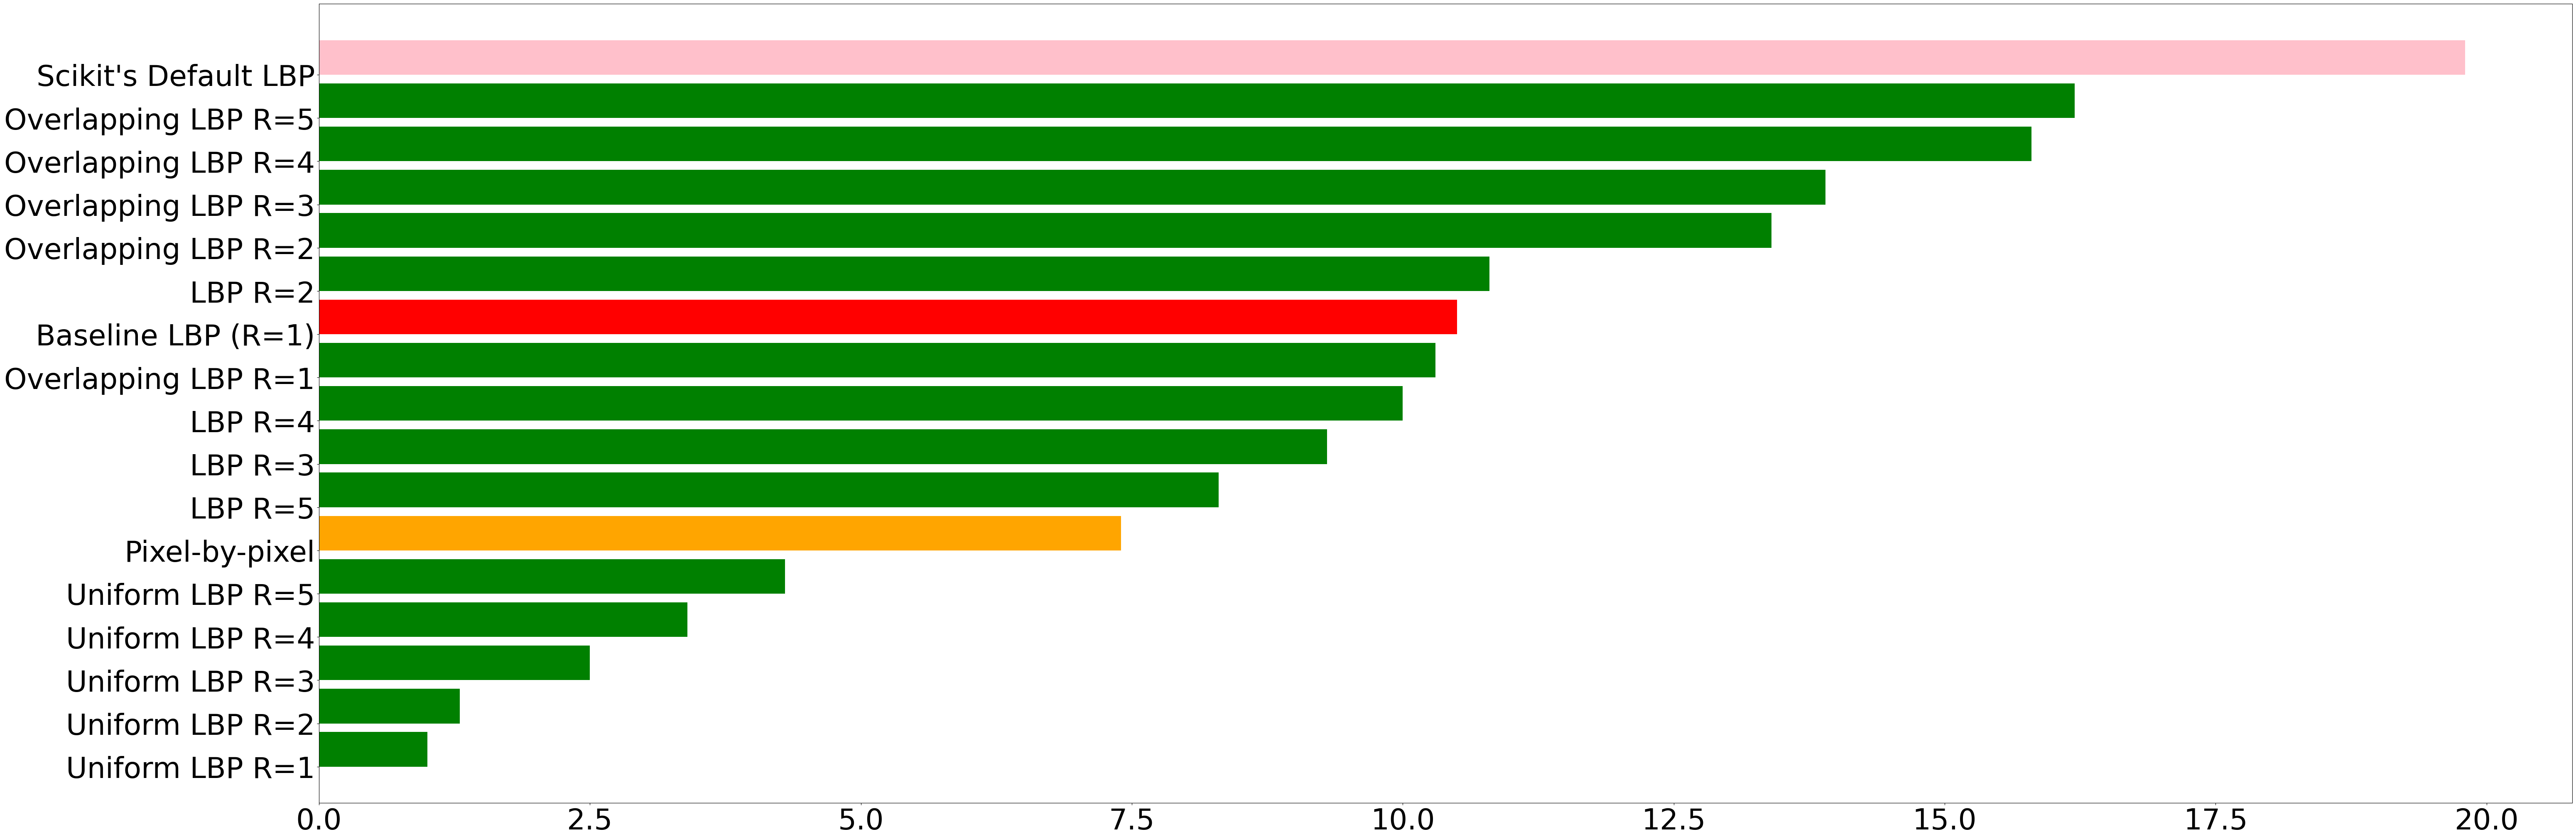

In [56]:
LBP_names = ["Pixel-by-pixel", 
    "Baseline LBP (R=1)", 
    "LBP R=2", 
    "LBP R=3", 
    "LBP R=4", 
    "LBP R=5", 
    "Overlapping LBP R=1", 
    "Overlapping LBP R=2", 
    "Overlapping LBP R=3", 
    "Overlapping LBP R=4", 
    "Overlapping LBP R=5", 
    "Uniform LBP R=1", 
    "Uniform LBP R=2", 
    "Uniform LBP R=3", 
    "Uniform LBP R=4", 
    "Uniform LBP R=5",
    "Scikit's Default LBP"]

LBP_results = [percentage_rank_one_pbp, 
    percentage_rank_one_baseline_LBP,  
    percentage_rank_one_5x5_LBP, 
    percentage_rank_one_7x7_LBP, 
    percentage_rank_one_9x9_LBP, 
    percentage_rank_one_11x11_LBP, 
    percentage_rank_one_overlapping_3x3_LBP, 
    percentage_rank_one_overlapping_5x5_LBP, 
    percentage_rank_one_overlapping_7x7_LBP, 
    percentage_rank_one_overlapping_9x9_LBP, 
    percentage_rank_one_overlapping_11x11_LBP, 
    percentage_rank_one_uniform_3x3_LBP, 
    percentage_rank_one_uniform_5x5_LBP, 
    percentage_rank_one_uniform_7x7_LBP, 
    percentage_rank_one_uniform_9x9_LBP, 
    percentage_rank_one_uniform_11x11_LBP, 
    percentage_rank_one_scikit]

df = pd.DataFrame(list(zip(LBP_names, LBP_results)),
                   columns=['Name', 'Rank-1'])

df = df.sort_values('Rank-1')


fig, ax = plt.subplots(1, figsize=(70, 25))
plt.rcParams.update({'font.size': 50})


ax.barh(df.Name, df["Rank-1"], align='edge', color='green')
ax.barh("Baseline LBP (R=1)", percentage_rank_one_baseline_LBP, align='edge', color='red')
ax.barh("Pixel-by-pixel", percentage_rank_one_pbp, align='edge', color='orange')
ax.barh("Scikit's Default LBP", percentage_rank_one_scikit, align='edge', color='pink')

plt.savefig("R1-Comparison.png")

plt.show()
